# 4. Evaluation

Final evaluation and comparison of all models:

1. Load trained models
2. Compare metrics across models
3. Visualize confusion matrices
4. Error analysis
5. Final conclusions

In [2]:
# Imports
import sys
sys.path.insert(0, '..')

import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from src import config
from src.data_utils import load_manifest
from src.dataset import create_dataloaders, RFDataset
from src.models import SimpleCNN, RandomForestModel, get_device
from src.evaluation import (
    compute_metrics,
    plot_confusion_matrix,
    plot_model_comparison,
    plot_learning_curves
)

plt.style.use('seaborn-v0_8-whitegrid')
device = get_device()
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load results from training
results_path = config.RESULTS_DIR / 'all_results.json'
if results_path.exists():
    with open(results_path) as f:
        all_results = json.load(f)
    print("Loaded results from training:")
    for model, metrics in all_results.items():
        print(f"  {model}: Acc={metrics['accuracy']:.4f}, F1={metrics['macro_f1']:.4f}")
else:
    print("No results file found. Please run the training notebook first.")
    all_results = {}

Loaded results from training:
  Random Forest: Acc=0.3110, F1=0.2471
  CNN: Acc=0.3307, F1=0.2668
  AST: Acc=0.5276, F1=0.5563


## 1. Model Comparison

In [4]:
# Create comparison table
if all_results:
    comparison_df = pd.DataFrame(all_results).T
    comparison_df.index.name = 'Model'
    
    # Format as percentages
    comparison_styled = comparison_df.style.format('{:.2%}')
    display(comparison_styled)
    
    # Save to CSV
    comparison_df.to_csv(config.RESULTS_DIR / 'model_comparison.csv')

,accuracy,macro_f1,macro_precision,macro_recall
Model,,,,
Random Forest,31.10%,24.71%,24.06%,28.81%
CNN,33.07%,26.68%,25.73%,30.16%
AST,52.76%,55.63%,57.72%,54.27%


Saved model comparison to c:\Users\adria\Desktop\zum_project\notebooks\..\results\model_comparison.png


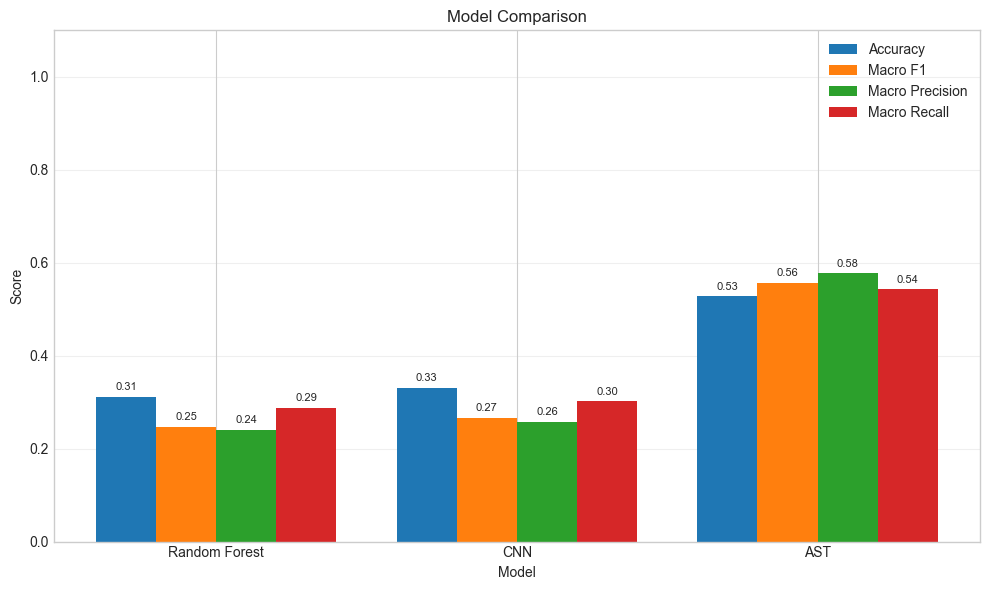

In [5]:
# Plot model comparison
if all_results:
    plot_model_comparison(all_results, save_path=config.RESULTS_DIR / 'model_comparison.png')

## 2. Per-Class Analysis

In [6]:
# Load per-class metrics from individual model files
per_class_data = []

for model_name in ['rf', 'cnn', 'ast']:
    metrics_path = config.RESULTS_DIR / f'metrics_{model_name}.json'
    if metrics_path.exists():
        with open(metrics_path) as f:
            metrics = json.load(f)
        
        for class_name, class_metrics in metrics.get('per_class', {}).items():
            per_class_data.append({
                'Model': metrics.get('model_name', model_name.upper()),
                'Class': class_name,
                'Precision': class_metrics['precision'],
                'Recall': class_metrics['recall'],
                'F1': class_metrics['f1']
            })

if per_class_data:
    per_class_df = pd.DataFrame(per_class_data)
    print("Per-class metrics:")
    display(per_class_df.pivot_table(index='Class', columns='Model', values='F1').round(4))

Per-class metrics:


Model,AST,CNN,Random Forest
Class,,,
drum_and_bass,0.7429,0.0000,0.0000
house,0.4902,0.3810,0.3762
techno,0.4725,0.2803,0.2013
trance,0.5195,0.4058,0.4110


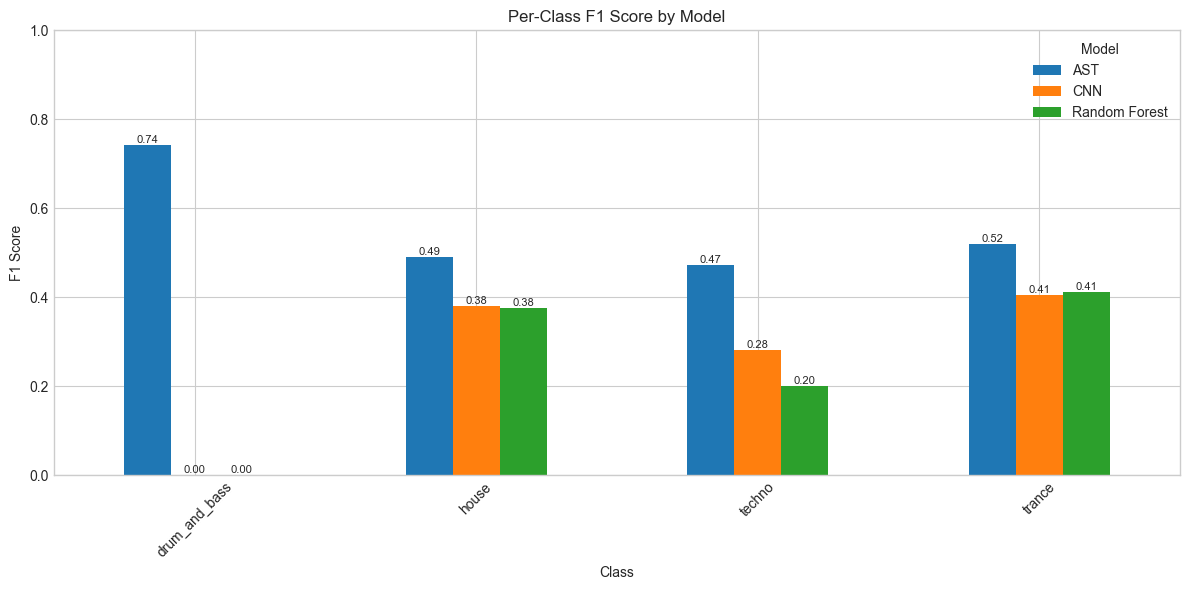

In [7]:
# Per-class F1 comparison chart
if per_class_data:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    pivot = per_class_df.pivot(index='Class', columns='Model', values='F1')
    pivot.plot(kind='bar', ax=ax)
    
    ax.set_title('Per-Class F1 Score by Model')
    ax.set_xlabel('Class')
    ax.set_ylabel('F1 Score')
    ax.legend(title='Model')
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=45)
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(config.RESULTS_DIR / 'per_class_f1.png', dpi=150)
    plt.show()

## 3. Confusion Matrices

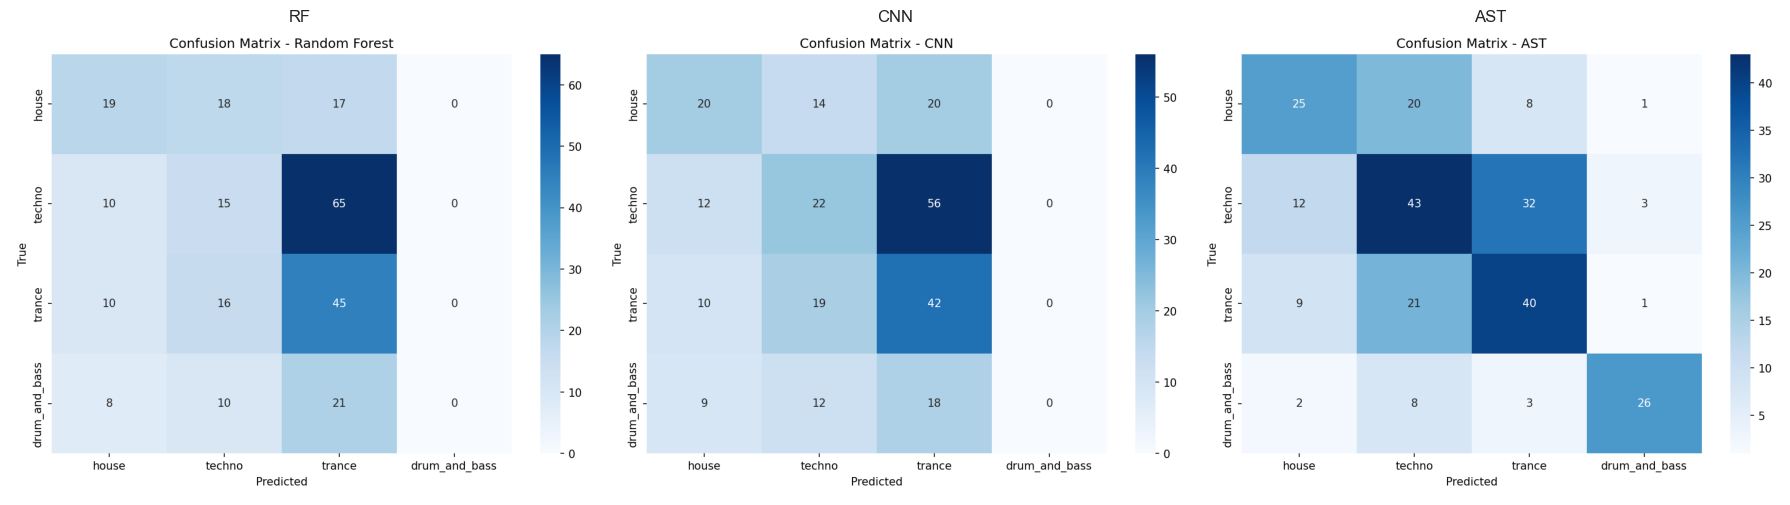

In [8]:
# Display confusion matrices side by side
from PIL import Image

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, model_name in enumerate(['rf', 'cnn', 'ast']):
    cm_path = config.RESULTS_DIR / f'confusion_matrix_{model_name}.png'
    if cm_path.exists():
        img = Image.open(cm_path)
        axes[i].imshow(img)
        axes[i].set_title(model_name.upper())
        axes[i].axis('off')
    else:
        axes[i].text(0.5, 0.5, f'{model_name.upper()}\nNot trained', 
                     ha='center', va='center', fontsize=14)
        axes[i].axis('off')

plt.tight_layout()
plt.savefig(config.RESULTS_DIR / 'all_confusion_matrices.png', dpi=150)
plt.show()

## 4. Learning Curves (CNN)

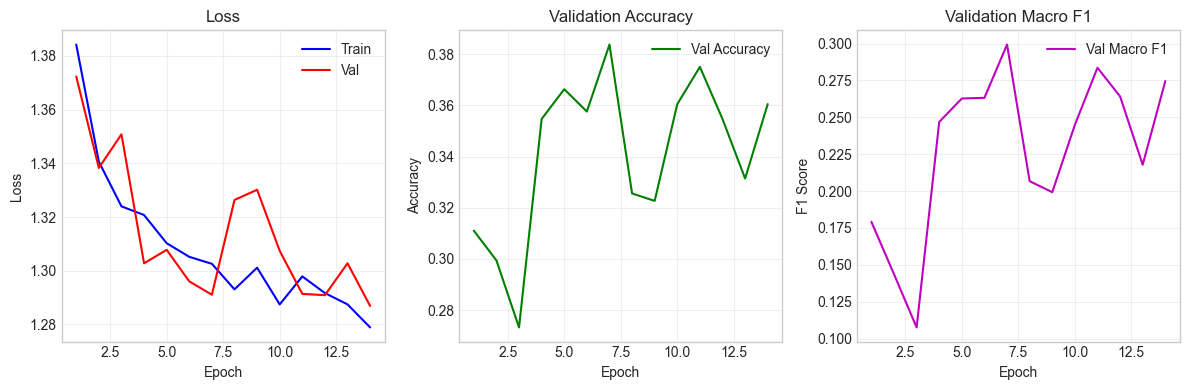

In [9]:
# Load and display CNN learning curves
history_path = config.MODELS_DIR / 'cnn' / 'history.json'
if history_path.exists():
    with open(history_path) as f:
        cnn_history = json.load(f)
    plot_learning_curves(cnn_history, save_path=None)
else:
    print("CNN history not found.")

## 5. Error Analysis

In [10]:
# Analyze common misclassifications
def analyze_confusion(cm, class_names):
    """Analyze confusion matrix to find common errors."""
    cm = np.array(cm)
    errors = []
    
    for i, true_class in enumerate(class_names):
        for j, pred_class in enumerate(class_names):
            if i != j and cm[i, j] > 0:
                errors.append({
                    'True': true_class,
                    'Predicted': pred_class,
                    'Count': cm[i, j],
                    'Rate': cm[i, j] / cm[i].sum() if cm[i].sum() > 0 else 0
                })
    
    return pd.DataFrame(errors).sort_values('Count', ascending=False)

# Load CNN metrics for analysis
cnn_metrics_path = config.RESULTS_DIR / 'metrics_cnn.json'
if cnn_metrics_path.exists():
    with open(cnn_metrics_path) as f:
        cnn_metrics = json.load(f)
    
    errors_df = analyze_confusion(
        cnn_metrics['confusion_matrix'],
        config.TARGET_CLASSES
    )
    
    print("Most common misclassifications (CNN):")
    display(errors_df.head(10))

Most common misclassifications (CNN):


,True,Predicted,Count,Rate
3,techno,trance,56,0.622222
1,house,trance,20,0.370370
5,trance,techno,19,0.267606
8,drum_and_bass,trance,18,0.461538
0,house,techno,14,0.259259
7,drum_and_bass,techno,12,0.307692
2,techno,house,12,0.133333
4,trance,house,10,0.140845
6,drum_and_bass,house,9,0.230769


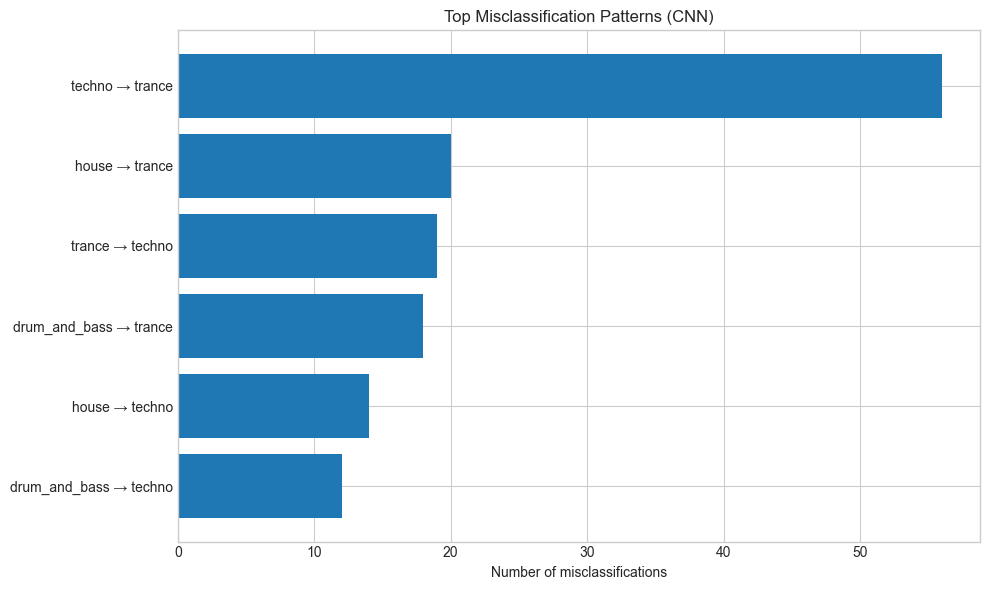

In [11]:
# Visualize error patterns
if cnn_metrics_path.exists():
    fig, ax = plt.subplots(figsize=(10, 6))
    
    top_errors = errors_df.head(6)
    labels = [f"{row['True']} → {row['Predicted']}" for _, row in top_errors.iterrows()]
    
    ax.barh(range(len(top_errors)), top_errors['Count'])
    ax.set_yticks(range(len(top_errors)))
    ax.set_yticklabels(labels)
    ax.set_xlabel('Number of misclassifications')
    ax.set_title('Top Misclassification Patterns (CNN)')
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.savefig(config.RESULTS_DIR / 'error_analysis.png', dpi=150)
    plt.show()

## 6. Conclusions

In [ ]:
print("="*60)
print("FINAL CONCLUSIONS")
print("="*60)

if all_results:
    # Find best model
    best_model = max(all_results.keys(), key=lambda x: all_results[x]['macro_f1'])
    best_f1 = all_results[best_model]['macro_f1']
    
    print(f"\n🏆 BEST MODEL: {best_model}")
    print(f"   Macro F1: {best_f1:.4f}")
    print(f"   Accuracy: {all_results[best_model]['accuracy']:.4f}")
    
    print("\n📊 MODEL RANKING (by Macro F1):")
    sorted_models = sorted(all_results.items(), key=lambda x: x[1]['macro_f1'], reverse=True)
    for i, (model, metrics) in enumerate(sorted_models, 1):
        print(f"   {i}. {model}: F1={metrics['macro_f1']:.4f}, Acc={metrics['accuracy']:.4f}")


print("\n" + "="*60)

FINAL CONCLUSIONS

🏆 BEST MODEL: AST
   Macro F1: 0.5563
   Accuracy: 0.5276

📊 MODEL RANKING (by Macro F1):
   1. AST: F1=0.5563, Acc=0.5276
   2. CNN: F1=0.2668, Acc=0.3307
   3. Random Forest: F1=0.2471, Acc=0.3110

